# <font color='orange'>  <center> NLP Project: ML Algorithms on Text Data

## <font color='orange'> Each student must extract tweets from twitter. Perform pre-processing and text representation. Apply ML algorithms for classification/clustering. <br> <br> 1. Creating Datasets <dd> a. Extract 5000 tweets with any 5 search labels of your choice. (1000 each). Eg(#cricket, #football, #basketball, #tennis, #hockey). <dd> b. Create one dataset for all the tweets extracted along with labels as second column. Shuffle the dataset. </dd> <br> <br>2. Pre-processing <dd> a. Clean the data by removing tags, user handles, numbers, and other characters. <dd> b. Stem tokens for basic vectorization <dd> c. Lemma tokens for embeddings </dd> <br> <br> 3. Text representation <dd> a. Vectorise each document in the dataset with tf-idf vectorization with n-grams (use stemmed data). <dd> b. Create document embeddings by summation of word vectors taken from any two pre-trained models. The tokens must be lemmas. </dd> <br> <br> 4. Apply machine learning techniques (any two algorithms) for classification/clustering on <dd> a. 3.a data <dd> b. 3.b data </dd> <br> <br> 5. Evaluate the results (4.a and 4.b) which outperforms. <dd> a. For clustering compare at least 10 records’ label with the clusters created. <dd> b. Present a chart as for classification:

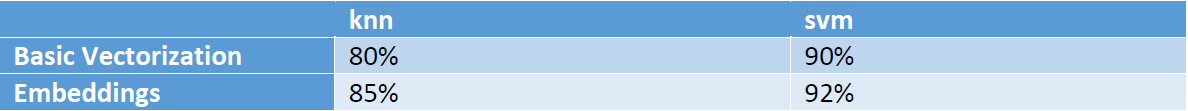

In [1]:
import twitter_info

import tweepy
from imdb import IMDb

import time
import json
import pandas as pd
import numpy as np
from iteration_utilities import deepflatten
from datetime import datetime
import os
import re
import glob
from tqdm import tqdm

from nltk.tokenize import word_tokenize
import nltk
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
lm = WordNetLemmatizer()
from nltk.stem.porter import PorterStemmer
pm = PorterStemmer()

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
#from sklearnex import patch_sklearn
#patch_sklearn()

import codecs
from glove import Corpus, Glove
from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from gensim.models import FastText
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.preprocessing import text, sequence
from keras import layers, models, optimizers

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

from pprint import pprint
import matplotlib.pyplot as plt
import seaborn as sn

from pickle import dump
from pickle import load

In [44]:
%run helper_functions.ipynb

In [3]:
consumer_key = twitter_info.API_Key
consumer_secret = twitter_info.API_Key_Secret
access_token = twitter_info.Access_Token
access_token_secret = twitter_info.Access_Token_Secret
bearer_token = twitter_info.Bearer_Token

In [4]:
client = tweepy.Client(bearer_token = bearer_token)
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
API = tweepy.API(auth, wait_on_rate_limit=True, retry_count=5, retry_delay=180)

In [5]:
s = str(datetime.now())
s = s[:16].replace(" ", "_").replace(":","")

In [6]:
class_list = ['Star Wars','Marvel Cinematic Universe','MonsterVerse','Wizarding World','DC Extended Universe']
class_query_list = []
class_file_name = ['input/star_wars_keywords.txt', 'input/Marvel_Cinematic_Universe_MCU_keywords.txt', 
                   'input/MonsterVerse_keywords.txt', 'input/Wizarding_World_keywords.txt', 'input/DC_Extended_Universe_keywords.txt']
class_keyword_list = []
for i in range(len(class_list)):
    with open(class_file_name[i]) as f:
        class_keyword_list.append(f.readlines())
    class_keyword_list[i] = [key_word.strip() + ' OR ' for key_word in class_keyword_list[i]]
    class_temp = ''.join(class_keyword_list[i])
    class_query_list.append(class_temp[:-4])

In [7]:
for i in range(len(class_list)):
    print("\n", class_query_list[i], class_list[i], len(class_query_list[i]), "\n")


 "Star Wars" OR "Darth Vader" OR "Obi-Wan Kenobi" OR "Yoda" OR "Princess Leia" OR "R2-D2" OR "Chewbacca" OR "Darth Maul" OR "C-3PO" OR "Q ira" OR "Uncle Owen" OR "Admiral Ackbar" OR "Jabba Hut" OR "Skywalker" OR "A New Hope" OR "Empire Strikes Back" OR "Return Jedi" OR "Phantom Menace" OR "Attack Clones" OR "Revenge Sith" OR "Force Awakens" OR "Last Jedi" OR "Clone Wars" Star Wars 372 


 "Marvel Cinematic Universe" OR "MCU" OR "Thor" OR "Ant Man" OR "Falcon" OR "Hulk" OR "Luke Cage" OR "Doctor Strange" OR "Groot" OR "Punisher" OR "Black Widow" OR "Jessica Jones" OR "Dare devil" OR "Captain America" OR "Loki" OR "Black Panther" OR "Spider Man" OR "Iron Man" OR "Scarlet Witch" OR "Captain Marvel" OR "Hawkeye" OR "Star Lord" OR "Thanos" OR "Eternals" OR "The Avengers" OR "Guardians of the Galaxy" Marvel Cinematic Universe 413 


 "MonsterVerse" OR "King Kong" OR "Anguirus" OR "Godzilla" OR "MechaKing Ghidorah" OR "Mechagodzilla" OR "King Ghidorah" OR "MUTO" OR "Monster X" OR "Mothra" OR

In [8]:
important_key_words = []
for i in range(len(class_list)):
    with open(class_file_name[i]) as f:
        lines = f.readlines()
        lines = [l.split() for l in lines]
        important_key_words.extend(lines)
important_key_words = list(deepflatten(important_key_words, depth=1))
important_key_words = [k.strip('"') for k in important_key_words]
print(important_key_words[:10])

['Star', 'Wars', 'Darth', 'Vader', 'Obi-Wan', 'Kenobi', 'Yoda', 'Princess', 'Leia', 'R2-D2']


In [9]:
print(len(important_key_words))
txt = " ".join(important_key_words)
selected_tags = []
processed_key_words_stem = preprocess_doc(txt, stem=True, lemma=False, stop_wrds=True, selected_tags=selected_tags)
print(len(processed_key_words_stem))
print(processed_key_words_stem)

216
199
['star', 'war', 'darth', 'vader', 'obi-wan', 'kenobi', 'yoda', 'princess', 'leia', 'chewbacca', 'darth', 'maul', 'ira', 'uncl', 'owen', 'admir', 'ackbar', 'jabba', 'hut', 'skywalk', 'new', 'hope', 'empir', 'strike', 'back', 'return', 'jedi', 'phantom', 'menac', 'attack', 'clone', 'reveng', 'sith', 'forc', 'awaken', 'last', 'jedi', 'clone', 'war', 'marvel', 'cinemat', 'univers', 'mcu', 'thor', 'ant', 'man', 'falcon', 'hulk', 'luke', 'cage', 'doctor', 'strang', 'groot', 'punish', 'black', 'widow', 'jessica', 'jone', 'dare', 'devil', 'captain', 'america', 'loki', 'black', 'panther', 'spider', 'man', 'iron', 'man', 'scarlet', 'witch', 'captain', 'marvel', 'hawkey', 'star', 'lord', 'thano', 'etern', 'aveng', 'guardian', 'galaxi', 'monstervers', 'king', 'kong', 'anguiru', 'godzilla', 'mechak', 'ghidorah', 'mechagodzilla', 'king', 'ghidorah', 'muto', 'monster', 'mothra', 'preston', 'packard', 'alan', 'jonah', 'emma', 'russel', 'mark', 'russel', 'jame', 'conrad', 'mason', 'weaver', 'fo

In [10]:
print(len(important_key_words))
txt = " ".join(important_key_words)
selected_tags = []
processed_key_words_lemma = preprocess_doc(txt, stem=False, lemma=True, stop_wrds=True, selected_tags=selected_tags)
print(len(processed_key_words_lemma))
print(processed_key_words_lemma)

216
199
['star', 'war', 'darth', 'vader', 'obi-wan', 'kenobi', 'yoda', 'princess', 'leia', 'chewbacca', 'darth', 'maul', 'ira', 'uncle', 'owen', 'admiral', 'ackbar', 'jabba', 'hut', 'skywalker', 'new', 'hope', 'empire', 'strike', 'back', 'return', 'jedi', 'phantom', 'menace', 'attack', 'clone', 'revenge', 'sith', 'force', 'awakens', 'last', 'jedi', 'clone', 'war', 'marvel', 'cinematic', 'universe', 'mcu', 'thor', 'ant', 'man', 'falcon', 'hulk', 'luke', 'cage', 'doctor', 'strange', 'groot', 'punisher', 'black', 'widow', 'jessica', 'jones', 'dare', 'devil', 'captain', 'america', 'loki', 'black', 'panther', 'spider', 'man', 'iron', 'man', 'scarlet', 'witch', 'captain', 'marvel', 'hawkeye', 'star', 'lord', 'thanos', 'eternals', 'avenger', 'guardian', 'galaxy', 'monsterverse', 'king', 'kong', 'anguirus', 'godzilla', 'mechaking', 'ghidorah', 'mechagodzilla', 'king', 'ghidorah', 'muto', 'monster', 'mothra', 'preston', 'packard', 'alan', 'jonah', 'emma', 'russell', 'mark', 'russell', 'james', 

In [11]:
%%time
for i in range(len(class_list)):
    print("\n", class_query_list[i], class_list[i], "\n")
    extract_tweets(class_query_list[i], class_list[i], fresh_load = False)


 "Star Wars" OR "Darth Vader" OR "Obi-Wan Kenobi" OR "Yoda" OR "Princess Leia" OR "R2-D2" OR "Chewbacca" OR "Darth Maul" OR "C-3PO" OR "Q ira" OR "Uncle Owen" OR "Admiral Ackbar" OR "Jabba Hut" OR "Skywalker" OR "A New Hope" OR "Empire Strikes Back" OR "Return Jedi" OR "Phantom Menace" OR "Attack Clones" OR "Revenge Sith" OR "Force Awakens" OR "Last Jedi" OR "Clone Wars" Star Wars 

Tweets extracted in output/tweets/ folder

 "Marvel Cinematic Universe" OR "MCU" OR "Thor" OR "Ant Man" OR "Falcon" OR "Hulk" OR "Luke Cage" OR "Doctor Strange" OR "Groot" OR "Punisher" OR "Black Widow" OR "Jessica Jones" OR "Dare devil" OR "Captain America" OR "Loki" OR "Black Panther" OR "Spider Man" OR "Iron Man" OR "Scarlet Witch" OR "Captain Marvel" OR "Hawkeye" OR "Star Lord" OR "Thanos" OR "Eternals" OR "The Avengers" OR "Guardians of the Galaxy" Marvel Cinematic Universe 

Tweets extracted in output/tweets/ folder

 "MonsterVerse" OR "King Kong" OR "Anguirus" OR "Godzilla" OR "MechaKing Ghidorah" O

In [12]:
df_all_tweet_list = []
class_output_files = []
list_output_files = [os.getcwd()+"\\output\\tweets\\"+f for f in os.listdir("output/tweets/")]
def find_label(file_name):
    for c in class_list:
        if(file_name.find(c) >= 0):
            return c
    return None
for f in list_output_files:
    class_output_files.append([find_label(f), f])
class_output_files

[['DC Extended Universe',
  'C:\\spark\\MCA\\Semester1\\E3_NLP\\Case_Study\\output\\tweets\\nlp_tweet_DC Extended Universe_2022-04-05_0332.csv'],
 ['Marvel Cinematic Universe',
  'C:\\spark\\MCA\\Semester1\\E3_NLP\\Case_Study\\output\\tweets\\nlp_tweet_Marvel Cinematic Universe_2022-04-05_0332.csv'],
 ['MonsterVerse',
  'C:\\spark\\MCA\\Semester1\\E3_NLP\\Case_Study\\output\\tweets\\nlp_tweet_MonsterVerse_2022-04-05_0332.csv'],
 ['Star Wars',
  'C:\\spark\\MCA\\Semester1\\E3_NLP\\Case_Study\\output\\tweets\\nlp_tweet_Star Wars_2022-04-05_0332.csv'],
 ['Wizarding World',
  'C:\\spark\\MCA\\Semester1\\E3_NLP\\Case_Study\\output\\tweets\\nlp_tweet_Wizarding World_2022-04-05_0332.csv']]

In [13]:
def get_full_text(label, file_name):
    df_temp = pd.read_csv(file_name)
    df_temp['label'] = label
    return df_temp[['full_text','label']]
class_tweet_list = []
for val in class_output_files:
    df_tweet_label = get_full_text(val[0], val[1])
    class_tweet_list.append(df_tweet_label)

In [14]:
final_tweet_df = pd.concat(class_tweet_list, axis=0, ignore_index=True)
final_tweet_df.to_csv("output/final_output/full_tweet_list.csv", index = False)
final_tweet_df

,full_text,label
0,Barnes &amp; Noble Pickup\n\nBarnes and Noble ...,DC Extended Universe
1,The True Crime Podcasts in the Batman universe...,DC Extended Universe
2,Want a free December's Dream Set!?❄🎀\nFollow m...,DC Extended Universe
3,I'm about to put some of my original artwork u...,DC Extended Universe
4,@Darmson2 @ALMUBAR04 @MUFC_Boogie @king_polams...,DC Extended Universe
...,...,...
49795,@essteeem Harry Potter movie series,Wizarding World
49796,my heart aches reminiscing ot/12 era (minus vo...,Wizarding World
49797,@bfsnailea Harry Potter,Wizarding World
49798,Next. #Hogwartle 92 3/6\n\n⬜⬜⬜⬜⬜\n🟩🟩⬜⬜⬜\n🟩🟩🟩🟩🟩...,Wizarding World


In [15]:
df_movies_id = pd.read_csv("input/imdb_movie_list.csv")
df_movies_id

,Universe,Movie_Name,IMDB_Movie_Id,Movie_Name_Key
0,Star Wars,A New Hope,76759,star_wars_a_new_hope
1,Star Wars,The Empire Strikes Back,80684,star_wars_the_empire_strikes_back
2,Star Wars,Return of the Jedi,86190,star_wars_episode_vi_return_of_the_jedi
3,Star Wars,The Phantom Menace,120915,star_wars_episode_i_the_phantom_menace
4,Star Wars,Attack of the Clones,121765,star_wars_episode_ii_attack_of_the_clones
...,...,...,...,...
59,Wizarding World,Harry Potter and the Half-Blood Prince,417741,harry_potter_and_the_half_blood_prince
60,Wizarding World,Harry Potter and the Deathly Hallows – Part 1,926084,harry_potter_and_the_deathly_hallows_part_1
61,Wizarding World,Harry Potter and the Deathly Hallows – Part 2,1201607,harry_potter_and_the_deathly_hallows_part_2
62,Wizarding World,Fantastic Beasts and Where to Find Them,3183660,fantastic_beasts_and_where_to_find_them


In [16]:
fresh_load=False
extract_imdb_reviews(df_movies_id, fresh_load)

Extracted IMDB reviews to output/final_output/full_imdb_review_list.csv


In [17]:
final_imdb_df = pd.read_csv("output/final_output/full_imdb_review_list.csv")
final_imdb_df.head()

,full_text,label
0,Henry Cavil is my Superman. He's the best Supe...,DC Extended Universe
1,"A QUICK "" DVD-REVIEW "" .HENRY CAVILL ⭐ CARRIES...",DC Extended Universe
2,Hands down the best Superman movie out there. ...,DC Extended Universe
3,At first I was very nervous at the prospect of...,DC Extended Universe
4,So we are looking at essentially a remake of S...,DC Extended Universe


In [18]:
final_input_df = pd.concat([final_imdb_df,final_tweet_df], axis=0, ignore_index=True)
final_input_df = final_input_df.sample(frac=1, random_state=42).reset_index(drop=True)    ## Shuffling Dataframe
final_input_df.to_csv("output/final_output/final_input_df.csv", index = False)

In [19]:
final_input_df = pd.read_csv("output/final_output/final_input_df.csv")
final_input_df

,full_text,label
0,‘#GuardiansoftheGalaxy 3’ Star #KarenGillan Sa...,Marvel Cinematic Universe
1,My friend recommend me a few shows and I have ...,DC Extended Universe
2,@Papa__Drago Godzilla would win easily but jus...,MonsterVerse
3,Batman &amp; Robin...It's so camp https://t.co...,DC Extended Universe
4,why is huge ant man moving so slow,Marvel Cinematic Universe
...,...,...
51457,@tortoisethatwon @aightmoe @Sarcasm_bender End...,DC Extended Universe
51458,@iHrtProngs SIRIUS BLACK DOES NOT HAVE A BAD H...,Wizarding World
51459,@aNorthernGarden @fiona_skywalker Agreed. She ...,Star Wars
51460,And so my long Marvel-watching journey comes t...,Marvel Cinematic Universe


In [20]:
tags = nltk.data.load('help/tagsets/upenn_tagset.pickle')
#nltk.help.upenn_tagset()
#selected_tags = ['NN','NNP','NNPS','NNS','JJ','JJR','JJS']
selected_tags = ['NN','NNP','NNPS','NNS']

In [21]:
sample_text = final_input_df['full_text'][2]
print(pos_tag(word_tokenize(sample_text)))
print(sample_text)
sample_text = preprocess_doc(sample_text, False, True, True, selected_tags)
print(sample_text)

[('@', 'NN'), ('Papa__Drago', 'NNP'), ('Godzilla', 'NNP'), ('would', 'MD'), ('win', 'VB'), ('easily', 'RB'), ('but', 'CC'), ('just', 'RB'), ('seeing', 'VBG'), ('him', 'PRP'), ('tear', 'VB'), ('through', 'IN'), ('hundreds', 'NNS'), ('of', 'IN'), ('titans', 'NNS'), ('WOULD', 'NNP'), ('BE', 'NNP'), ('SO', 'NNP'), ('FREAKING', 'NNP'), ('COOL', 'NNP'), ('!', '.'), ('OMG', 'NN')]
@Papa__Drago Godzilla would win easily but just seeing him tear through hundreds of titans WOULD BE SO FREAKING COOL! OMG
['papa', 'drago', 'godzilla', 'titan', 'omg']


In [22]:
extract_stems_lemma(selected_tags, final_input_df, fresh_load= False)

Stems and Lemma extracted to output/final_output/final_input_cleaned_stem_lemma.csv


In [23]:
final_input_df = pd.read_csv("output/final_output/final_input_cleaned_stem_lemma.csv")

In [24]:
final_input_df['label_id'] = final_input_df['label'].astype("category").cat.codes
final_input_df

,full_text,label,stem_cleaned_tokens,lemma_cleaned_tokens,label_id
0,‘#GuardiansoftheGalaxy 3’ Star #KarenGillan Sa...,Marvel Cinematic Universe,"['guardiansofthegalaxi', 'star', 'karengillan'...","['guardiansofthegalaxy', 'star', 'karengillan'...",1
1,My friend recommend me a few shows and I have ...,DC Extended Universe,"['friend', 'show', 'idea', 'flash', 'guy', 'sh...","['friend', 'show', 'idea', 'flash', 'guy', 'sh...",0
2,@Papa__Drago Godzilla would win easily but jus...,MonsterVerse,"['papa', 'drago', 'godzilla', 'hundr', 'titan'...","['papa', 'drago', 'godzilla', 'titan', 'omg']",2
3,Batman &amp; Robin...It's so camp https://t.co...,DC Extended Universe,"['batman', 'robin', 'camp']","['batman', 'robin', 'camp']",0
4,why is huge ant man moving so slow,Marvel Cinematic Universe,"['ant', 'man', 'move']","['ant', 'man']",1
...,...,...,...,...,...
51457,@tortoisethatwon @aightmoe @Sarcasm_bender End...,DC Extended Universe,"['tortoisethatwon', 'aightmo', 'sarcasm', 'ben...","['tortoisethatwon', 'aightmoe', 'sarcasm', 'be...",0
51458,@iHrtProngs SIRIUS BLACK DOES NOT HAVE A BAD H...,Wizarding World,"['hair', 'day']","['ihrtprongs', 'hair', 'day']",4
51459,@aNorthernGarden @fiona_skywalker Agreed. She ...,Star Wars,"['fiona', 'skywalk', 'liter', 'ask', 'comment'...","['fiona', 'skywalker', 'input', 'earns', 'hous...",3
51460,And so my long Marvel-watching journey comes t...,Marvel Cinematic Universe,"['marvel-watch', 'journey', 'caught', 'endless...","['journey', 'end', 'franchise', 'eon', 'rest',...",1


In [25]:
df_vectorization = final_input_df[['stem_cleaned_tokens', 'label', 'label_id']]
df_vectorization.head()

,stem_cleaned_tokens,label,label_id
0,"['guardiansofthegalaxi', 'star', 'karengillan'...",Marvel Cinematic Universe,1
1,"['friend', 'show', 'idea', 'flash', 'guy', 'sh...",DC Extended Universe,0
2,"['papa', 'drago', 'godzilla', 'hundr', 'titan'...",MonsterVerse,2
3,"['batman', 'robin', 'camp']",DC Extended Universe,0
4,"['ant', 'man', 'move']",Marvel Cinematic Universe,1


In [26]:
dfvg = df_vectorization.groupby(['label', 'label_id'])
classes = {}
for d in dfvg:
    classes[d[0][1]] = d[0][0]
print(classes)

{0: 'DC Extended Universe', 1: 'Marvel Cinematic Universe', 2: 'MonsterVerse', 3: 'Star Wars', 4: 'Wizarding World'}


In [27]:
df_embedding = final_input_df[['lemma_cleaned_tokens', 'label', 'label_id']]
df_embedding.head()

,lemma_cleaned_tokens,label,label_id
0,"['guardiansofthegalaxy', 'star', 'karengillan'...",Marvel Cinematic Universe,1
1,"['friend', 'show', 'idea', 'flash', 'guy', 'sh...",DC Extended Universe,0
2,"['papa', 'drago', 'godzilla', 'titan', 'omg']",MonsterVerse,2
3,"['batman', 'robin', 'camp']",DC Extended Universe,0
4,"['ant', 'man']",Marvel Cinematic Universe,1


In [28]:
len(df_embedding)

51462

In [29]:
%%time
list_stemmed_data = []
list_embedding_data = []
for i in df_vectorization.index:
    exec("lst = " + df_vectorization['stem_cleaned_tokens'][i])
    lst = clean_tokens(lst)
    list_stemmed_data.append(" ".join(lst))
    exec("lst2 = " + df_embedding['lemma_cleaned_tokens'][i])
    lst2 = clean_tokens(lst2)
    list_embedding_data.append(" ".join(lst2))

Wall time: 6.87 s


# <font color='orange'>  <center> Basic Vectorization

In [30]:
%%time
tf_idf_vectorizer = TfidfVectorizer(ngram_range = (1,3), analyzer='word', min_df=2)
vectorized_text=tf_idf_vectorizer.fit_transform(list_stemmed_data)

Wall time: 2.35 s


In [31]:
tf_idf_vectors = tf_idf_vectorizer.get_feature_names_out()
tf_idf_vectors

array(['abaddon', 'abaga', 'abaga eniolamaf', ..., 'zuri whitak',
       'zxshadowacexz', 'zypisfi'], dtype=object)

In [32]:
len(tf_idf_vectors)

84351

In [33]:
dump(tf_idf_vectorizer,open('models/tfidf_stem_vector.pkl', 'wb'))

In [34]:
tf_idf_vectorizer = load(open('models/tfidf_stem_vector.pkl', 'rb'))

In [35]:
%%time
X_sv=vectorized_text
y_sv=list(df_vectorization['label_id'])
print(X_sv.shape)
print(len(y_sv))
X_train_sv, X_test_sv, y_train_sv, y_test_sv = train_test_split(X_sv, y_sv, test_size = 0.3, shuffle = True, stratify = y_sv, random_state = 3)

(51462, 84351)
51462
Wall time: 36.9 ms


# <font color='orange'>  <center> TFIDF Multinomial Naive Bayes model

------------------------------------------------------------------------------------------------------------------------
Train Accuracy Score of TFIDF Multinomial Naive Bayes model created using stemmed tf_idf vector is:
 0.9618299419815118
------------------------------------------------------------------------------------------------------------------------
Test Accuracy Score of TFIDF Multinomial Naive Bayes model created using stemmed tf_idf vector is:
 0.9154090290821945
------------------------------------------------------------------------------------------------------------------------
Confusion Matrix:
[[2682  232   55   52   35]
 [ 127 2918   39   73   54]
 [  92  133 2725   45   36]
 [  40   82   25 2878   38]
 [  32   68   17   31 2930]]


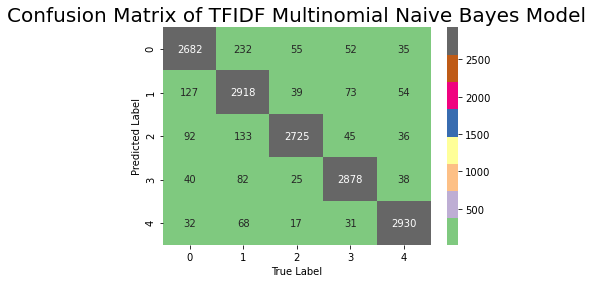

{0: 'DC Extended Universe', 1: 'Marvel Cinematic Universe', 2: 'MonsterVerse', 3: 'Star Wars', 4: 'Wizarding World'}
------------------------------------------------------------------------------------------------------------------------
('              precision    recall  f1-score   support\n'
 '\n'
 '           0       0.90      0.88      0.89      3056\n'
 '           1       0.85      0.91      0.88      3211\n'
 '           2       0.95      0.90      0.92      3031\n'
 '           3       0.93      0.94      0.94      3063\n'
 '           4       0.95      0.95      0.95      3078\n'
 '\n'
 '    accuracy                           0.92     15439\n'
 '   macro avg       0.92      0.92      0.92     15439\n'
 'weighted avg       0.92      0.92      0.92     15439\n')
Wall time: 414 ms


In [36]:
%%time
tfidf_mnb_model = MultinomialNB()
tfidf_mnb_model, score_tfidf_mnb = evaluate_model(X_train_sv, y_train_sv, X_test_sv, y_test_sv, classes, 
                                         tfidf_mnb_model, "TFIDF Multinomial Naive Bayes", "tfidf_mnb_model.pkl", fresh_load=True)

In [37]:
get_cross_val(tfidf_mnb_model, X_train_sv, y_train_sv, X_test_sv, y_test_sv)

Cross validation over 10 folds:  0.9140825871092986


array([1, 2, 0, ..., 2, 0, 0])

In [38]:
tf_idf_vectorizer = load(open('models/tfidf_stem_vector.pkl', 'rb'))
tfidf_mnb_model = load(open('models/tfidf_mnb_model.pkl', 'rb'))

In [39]:
output_file_name = "input/rottentomatoes_reviews_final.csv"
df_rottentomatoes_reviews = pd.read_csv(output_file_name)

In [40]:
df_rottentomatoes_reviews[["review", "label_name"]]

,review,label_name
0,"2019's Godzilla: King of the Monsters, does pr...",MonsterVerse
1,"Shazam!, it's wonderful. It's a very well-dire...",DC Extended Universe
2,The crimes of Grindelwald is a very good film ...,Wizarding World
3,An entertaining film with a great villain and ...,Marvel Cinematic Universe
4,Captain America: Civil War goes a darker direc...,Marvel Cinematic Universe
...,...,...
260,Shazam is fun and entertaining! It succeeds in...,DC Extended Universe
261,Godzilla: King of the Monsters was the first M...,MonsterVerse
262,"Not quite top tier MCU, but very close. This i...",Marvel Cinematic Universe
263,There are a lot of mixed feeling about this mo...,Marvel Cinematic Universe


In [41]:
%%time
classes = {0: 'DC Extended Universe', 1: 'Marvel Cinematic Universe', 2: 'MonsterVerse', 3: 'Star Wars', 4: 'Wizarding World'}
valid_tfidf_vec_list = []
for i in df_rottentomatoes_reviews.index:
    validation_text = df_rottentomatoes_reviews["review"][i]
    validation_text = preprocess_doc(validation_text, stem = True, lemma = False, stop_wrds = True, selected_tags = selected_tags)
    vec = tf_idf_vectorizer.transform(validation_text)
    valid_tfidf_vec_list.append(vec)

Wall time: 11.2 s


In [45]:
%%time
val_acc_scr_tfidf_mnb, df_rottentomatoes_reviews = validate_model(tfidf_mnb_model, "TFIDF Multinomial Naive Bayes", "tfidf_MNB", df_rottentomatoes_reviews, valid_tfidf_vec_list)

Validation Accuracy Score of TFIDF Multinomial Naive Bayes Model created using stemmed tf_idf vector is:
 0.7433962264150943
Wall time: 476 ms


In [46]:
df_rottentomatoes_reviews.to_csv("output/final_output/df_rottentomatoes_reviews_predicted"+s+".csv", index = False)
df_rottentomatoes_reviews

,review,movie_name,label_name,predicted_label_MNB,y_true,y_pred_MNB,predicted_label_tfidf_rfc,y_pred_tfidf_rfc,predicted_label_tfidf_MNB,y_pred_tfidf_MNB
0,"2019's Godzilla: King of the Monsters, does pr...",godzilla_king_of_the_monsters_2019,MonsterVerse,MonsterVerse,2,2,MonsterVerse,2,MonsterVerse,2
1,"Shazam!, it's wonderful. It's a very well-dire...",shazam,DC Extended Universe,DC Extended Universe,0,0,DC Extended Universe,0,Marvel Cinematic Universe,1
2,The crimes of Grindelwald is a very good film ...,fantastic_beasts_the_crimes_of_grindelwald,Wizarding World,Wizarding World,4,4,MonsterVerse,2,DC Extended Universe,0
3,An entertaining film with a great villain and ...,spider_man_homecoming,Marvel Cinematic Universe,Marvel Cinematic Universe,1,1,Marvel Cinematic Universe,1,Marvel Cinematic Universe,1
4,Captain America: Civil War goes a darker direc...,captain_america_civil_war,Marvel Cinematic Universe,Marvel Cinematic Universe,1,1,Marvel Cinematic Universe,1,Marvel Cinematic Universe,1
...,...,...,...,...,...,...,...,...,...,...
260,Shazam is fun and entertaining! It succeeds in...,shazam,DC Extended Universe,DC Extended Universe,0,0,DC Extended Universe,0,DC Extended Universe,0
261,Godzilla: King of the Monsters was the first M...,godzilla_king_of_the_monsters_2019,MonsterVerse,MonsterVerse,2,2,MonsterVerse,2,MonsterVerse,2
262,"Not quite top tier MCU, but very close. This i...",avengers_infinity_war,Marvel Cinematic Universe,Marvel Cinematic Universe,1,1,DC Extended Universe,0,Marvel Cinematic Universe,1
263,There are a lot of mixed feeling about this mo...,thor_the_dark_world,Marvel Cinematic Universe,Marvel Cinematic Universe,1,1,DC Extended Universe,0,Marvel Cinematic Universe,1


# <font color='orange'>  <center> TFIDF Support Vector Classifier

Train Accuracy Score of TFIDF Support Vector Classifier model created using stemmed tf_idf vector is:
 0.9895344640923854
------------------------------------------------------------------------------------------------------------------------
Test Accuracy Score of TFIDF Support Vector Classifier model created using stemmed tf_idf vector is:
 0.9172226180452102
------------------------------------------------------------------------------------------------------------------------
Confusion Matrix:
[[2753  262   15   15   11]
 [ 171 2983   16   29   12]
 [ 132  183 2696   14    6]
 [  72  126   10 2838   17]
 [  50  102   10   25 2891]]


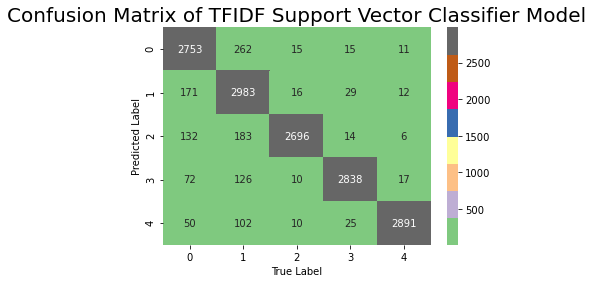

{0: 'DC Extended Universe', 1: 'Marvel Cinematic Universe', 2: 'MonsterVerse', 3: 'Star Wars', 4: 'Wizarding World'}
------------------------------------------------------------------------------------------------------------------------
('              precision    recall  f1-score   support\n'
 '\n'
 '           0       0.87      0.90      0.88      3056\n'
 '           1       0.82      0.93      0.87      3211\n'
 '           2       0.98      0.89      0.93      3031\n'
 '           3       0.97      0.93      0.95      3063\n'
 '           4       0.98      0.94      0.96      3078\n'
 '\n'
 '    accuracy                           0.92     15439\n'
 '   macro avg       0.92      0.92      0.92     15439\n'
 'weighted avg       0.92      0.92      0.92     15439\n')
Wall time: 2min 21s


In [47]:
%%time
tfidf_svc_model = SVC()
tfidf_svc_model, score_tfidf_svc = evaluate_model(X_train_sv, y_train_sv, X_test_sv, y_test_sv, classes, 
                                         tfidf_svc_model, "TFIDF Support Vector Classifier", "tfidf_svc_model.pkl", fresh_load=False)

In [48]:
tf_idf_vectorizer = load(open('models/tfidf_stem_vector.pkl', 'rb'))
tfidf_svc_model = load(open('models/tfidf_svc_model.pkl', 'rb'))

In [49]:
list_f = sorted(glob.glob("output/final_output/df_rottentomatoes_reviews_predicted*"), key=os.path.getmtime)
output_file_name = list_f[0]
df_rottentomatoes_reviews = pd.read_csv(output_file_name)

In [50]:
%%time
val_acc_scr_tfidf_svc, df_rottentomatoes_reviews = validate_model(tfidf_svc_model, "TFIDF Support Vector Classifier", "tfidf_svc", df_rottentomatoes_reviews, valid_tfidf_vec_list)

Validation Accuracy Score of TFIDF Support Vector Classifier Model created using stemmed tf_idf vector is:
 0.6490566037735849
Wall time: 16.4 s


In [51]:
df_rottentomatoes_reviews.to_csv(output_file_name, index = False)
df_rottentomatoes_reviews

,review,movie_name,label_name,predicted_label_MNB,y_true,y_pred_MNB,predicted_label_svc,y_pred_svc,predicted_label_knn,y_pred_knn,predicted_label_we_rfc,y_pred_we_rfc,predicted_label_we_mnb,y_pred_we_mnb,predicted_label_tfidf_knn,y_pred_tfidf_knn,predicted_label_tfidf_svc,y_pred_tfidf_svc
0,"2019's Godzilla: King of the Monsters, does pr...",godzilla_king_of_the_monsters_2019,MonsterVerse,MonsterVerse,2,2,MonsterVerse,2,MonsterVerse,2,MonsterVerse,2,Marvel Cinematic Universe,1,MonsterVerse,2,MonsterVerse,2
1,"Shazam!, it's wonderful. It's a very well-dire...",shazam,DC Extended Universe,DC Extended Universe,0,0,DC Extended Universe,0,DC Extended Universe,0,DC Extended Universe,0,Wizarding World,4,DC Extended Universe,0,Marvel Cinematic Universe,1
2,The crimes of Grindelwald is a very good film ...,fantastic_beasts_the_crimes_of_grindelwald,Wizarding World,Wizarding World,4,4,DC Extended Universe,0,Marvel Cinematic Universe,1,MonsterVerse,2,Marvel Cinematic Universe,1,MonsterVerse,2,DC Extended Universe,0
3,An entertaining film with a great villain and ...,spider_man_homecoming,Marvel Cinematic Universe,Marvel Cinematic Universe,1,1,Marvel Cinematic Universe,1,Marvel Cinematic Universe,1,Marvel Cinematic Universe,1,Star Wars,3,MonsterVerse,2,Marvel Cinematic Universe,1
4,Captain America: Civil War goes a darker direc...,captain_america_civil_war,Marvel Cinematic Universe,Marvel Cinematic Universe,1,1,Marvel Cinematic Universe,1,Marvel Cinematic Universe,1,Marvel Cinematic Universe,1,Star Wars,3,Marvel Cinematic Universe,1,Marvel Cinematic Universe,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
260,Shazam is fun and entertaining! It succeeds in...,shazam,DC Extended Universe,DC Extended Universe,0,0,DC Extended Universe,0,DC Extended Universe,0,DC Extended Universe,0,Marvel Cinematic Universe,1,DC Extended Universe,0,DC Extended Universe,0
261,Godzilla: King of the Monsters was the first M...,godzilla_king_of_the_monsters_2019,MonsterVerse,MonsterVerse,2,2,MonsterVerse,2,MonsterVerse,2,MonsterVerse,2,Marvel Cinematic Universe,1,MonsterVerse,2,MonsterVerse,2
262,"Not quite top tier MCU, but very close. This i...",avengers_infinity_war,Marvel Cinematic Universe,Marvel Cinematic Universe,1,1,Marvel Cinematic Universe,1,DC Extended Universe,0,Star Wars,3,MonsterVerse,2,Marvel Cinematic Universe,1,Marvel Cinematic Universe,1
263,There are a lot of mixed feeling about this mo...,thor_the_dark_world,Marvel Cinematic Universe,Marvel Cinematic Universe,1,1,Marvel Cinematic Universe,1,DC Extended Universe,0,DC Extended Universe,0,Star Wars,3,Marvel Cinematic Universe,1,Marvel Cinematic Universe,1


# <font color='orange'>  <center> TFIDF KNN Classifier

------------------------------------------------------------------------------------------------------------------------
Train Accuracy Score of TFIDF K-Nearest Neighbor(KNN) model created using stemmed tf_idf vector is:
 0.6454765011242817
------------------------------------------------------------------------------------------------------------------------
Test Accuracy Score of TFIDF K-Nearest Neighbor(KNN) model created using stemmed tf_idf vector is:
 0.4653798821167174
------------------------------------------------------------------------------------------------------------------------
Confusion Matrix:
[[1759  708  387   67  135]
 [ 905 1724  396   68  118]
 [ 857  779 1235   48  112]
 [ 712  627  369 1248  107]
 [ 720  680  397   62 1219]]


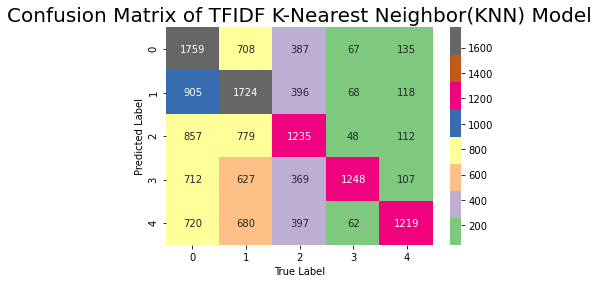

{0: 'DC Extended Universe', 1: 'Marvel Cinematic Universe', 2: 'MonsterVerse', 3: 'Star Wars', 4: 'Wizarding World'}
------------------------------------------------------------------------------------------------------------------------
('              precision    recall  f1-score   support\n'
 '\n'
 '           0       0.36      0.58      0.44      3056\n'
 '           1       0.38      0.54      0.45      3211\n'
 '           2       0.44      0.41      0.42      3031\n'
 '           3       0.84      0.41      0.55      3063\n'
 '           4       0.72      0.40      0.51      3078\n'
 '\n'
 '    accuracy                           0.47     15439\n'
 '   macro avg       0.55      0.46      0.47     15439\n'
 'weighted avg       0.55      0.47      0.47     15439\n')
Wall time: 56.4 s


In [52]:
%%time
tfidf_knn_model = KNeighborsClassifier(5)
tfidf_knn_model, score_tfidf_knn = evaluate_model(X_train_sv, y_train_sv, X_test_sv, y_test_sv, classes, 
                                         tfidf_knn_model, "TFIDF K-Nearest Neighbor(KNN)", "tfidf_knn_model.pkl", fresh_load=True)

In [53]:
tf_idf_vectorizer = load(open('models/tfidf_stem_vector.pkl', 'rb'))
tfidf_knn_model = load(open('models/tfidf_knn_model.pkl', 'rb'))

In [54]:
list_f = sorted(glob.glob("output/final_output/df_rottentomatoes_reviews_predicted*"), key=os.path.getmtime)
output_file_name = list_f[0]
df_rottentomatoes_reviews = pd.read_csv(output_file_name)

In [55]:
%%time
val_acc_scr_tfidf_knn, df_rottentomatoes_reviews = validate_model(tfidf_knn_model, "TFIDF K-Nearest Neighbor(KNN)", "tfidf_knn", df_rottentomatoes_reviews, valid_tfidf_vec_list)

Validation Accuracy Score of TFIDF K-Nearest Neighbor(KNN) Model created using stemmed tf_idf vector is:
 0.5471698113207547
Wall time: 13.2 s


In [56]:
#%%time
#get_cross_val(tfidf_knn_model, X_train_sv, y_train_sv, X_test_sv, y_test_sv)

In [57]:
df_rottentomatoes_reviews.to_csv(output_file_name, index = False)
df_rottentomatoes_reviews

,review,movie_name,label_name,predicted_label_MNB,y_true,y_pred_MNB,predicted_label_tfidf_rfc,y_pred_tfidf_rfc,predicted_label_tfidf_MNB,y_pred_tfidf_MNB,predicted_label_tfidf_knn,y_pred_tfidf_knn
0,"2019's Godzilla: King of the Monsters, does pr...",godzilla_king_of_the_monsters_2019,MonsterVerse,MonsterVerse,2,2,MonsterVerse,2,MonsterVerse,2,MonsterVerse,2
1,"Shazam!, it's wonderful. It's a very well-dire...",shazam,DC Extended Universe,DC Extended Universe,0,0,DC Extended Universe,0,DC Extended Universe,0,Marvel Cinematic Universe,1
2,The crimes of Grindelwald is a very good film ...,fantastic_beasts_the_crimes_of_grindelwald,Wizarding World,Wizarding World,4,4,MonsterVerse,2,Wizarding World,4,DC Extended Universe,0
3,An entertaining film with a great villain and ...,spider_man_homecoming,Marvel Cinematic Universe,Marvel Cinematic Universe,1,1,Marvel Cinematic Universe,1,Marvel Cinematic Universe,1,Marvel Cinematic Universe,1
4,Captain America: Civil War goes a darker direc...,captain_america_civil_war,Marvel Cinematic Universe,Marvel Cinematic Universe,1,1,Marvel Cinematic Universe,1,Marvel Cinematic Universe,1,Marvel Cinematic Universe,1
...,...,...,...,...,...,...,...,...,...,...,...,...
260,Shazam is fun and entertaining! It succeeds in...,shazam,DC Extended Universe,DC Extended Universe,0,0,DC Extended Universe,0,DC Extended Universe,0,DC Extended Universe,0
261,Godzilla: King of the Monsters was the first M...,godzilla_king_of_the_monsters_2019,MonsterVerse,MonsterVerse,2,2,MonsterVerse,2,MonsterVerse,2,MonsterVerse,2
262,"Not quite top tier MCU, but very close. This i...",avengers_infinity_war,Marvel Cinematic Universe,Marvel Cinematic Universe,1,1,Marvel Cinematic Universe,1,Marvel Cinematic Universe,1,Marvel Cinematic Universe,1
263,There are a lot of mixed feeling about this mo...,thor_the_dark_world,Marvel Cinematic Universe,Marvel Cinematic Universe,1,1,Marvel Cinematic Universe,1,Marvel Cinematic Universe,1,DC Extended Universe,0


# <font color='orange'>  <center> TFIDF Random Forest Classifier

------------------------------------------------------------------------------------------------------------------------
Train Accuracy Score of TFIDF Random Forest Classifier model created using stemmed tf_idf vector is:
 0.9923382283541071
------------------------------------------------------------------------------------------------------------------------
Test Accuracy Score of TFIDF Random Forest Classifier model created using stemmed tf_idf vector is:
 0.9182589545955049
------------------------------------------------------------------------------------------------------------------------
Confusion Matrix:
[[2714  247   47   19   29]
 [ 161 2918   61   50   21]
 [  88  159 2743   25   16]
 [  55   83   29 2878   18]
 [  35   74   19   26 2924]]


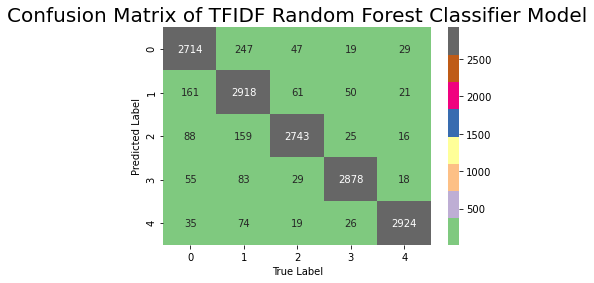

{0: 'DC Extended Universe', 1: 'Marvel Cinematic Universe', 2: 'MonsterVerse', 3: 'Star Wars', 4: 'Wizarding World'}
------------------------------------------------------------------------------------------------------------------------
('              precision    recall  f1-score   support\n'
 '\n'
 '           0       0.89      0.89      0.89      3056\n'
 '           1       0.84      0.91      0.87      3211\n'
 '           2       0.95      0.90      0.93      3031\n'
 '           3       0.96      0.94      0.95      3063\n'
 '           4       0.97      0.95      0.96      3078\n'
 '\n'
 '    accuracy                           0.92     15439\n'
 '   macro avg       0.92      0.92      0.92     15439\n'
 'weighted avg       0.92      0.92      0.92     15439\n')
Wall time: 1min 45s


In [58]:
%%time
tfidf_rndm_frst_model = RandomForestClassifier(n_estimators=50)
tfidf_rndm_frst_model, score_tfidf_rfc = evaluate_model(X_train_sv, y_train_sv, X_test_sv, y_test_sv, classes, 
                                         tfidf_rndm_frst_model, "TFIDF Random Forest Classifier", "tfidf_rndm_frst_model.pkl", fresh_load=True)

In [59]:
tf_idf_vectorizer = load(open('models/tfidf_stem_vector.pkl', 'rb'))
tfidf_rndm_frst_model = load(open('models/tfidf_rndm_frst_model.pkl', 'rb'))

In [60]:
list_f = sorted(glob.glob("output/final_output/df_rottentomatoes_reviews_predicted*"), key=os.path.getmtime)
output_file_name = list_f[0]
df_rottentomatoes_reviews = pd.read_csv(output_file_name)

In [61]:
%%time
val_acc_scr_tfidf_rfc, df_rottentomatoes_reviews = validate_model(tfidf_rndm_frst_model, "TFIDF Random Forest Classifier", "tfidf_rfc", df_rottentomatoes_reviews, valid_tfidf_vec_list)

Validation Accuracy Score of TFIDF Random Forest Classifier Model created using stemmed tf_idf vector is:
 0.5471698113207547
Wall time: 4.4 s


In [62]:
#%%time
#get_cross_val(tfidf_rndm_frst_model, X_train_sv, y_train_sv, X_test_sv, y_test_sv)

In [63]:
df_rottentomatoes_reviews.to_csv(output_file_name, index = False)
df_rottentomatoes_reviews

,review,movie_name,label_name,predicted_label_MNB,y_true,y_pred_MNB,predicted_label_tfidf_svc,y_pred_tfidf_svc,predicted_label_tfidf_xgb,y_pred_tfidf_xgb,predicted_label_tfidf_rfc,y_pred_tfidf_rfc
0,"2019's Godzilla: King of the Monsters, does pr...",godzilla_king_of_the_monsters_2019,MonsterVerse,MonsterVerse,2,2,MonsterVerse,2,MonsterVerse,2,MonsterVerse,2
1,"Shazam!, it's wonderful. It's a very well-dire...",shazam,DC Extended Universe,DC Extended Universe,0,0,DC Extended Universe,0,DC Extended Universe,0,Marvel Cinematic Universe,1
2,The crimes of Grindelwald is a very good film ...,fantastic_beasts_the_crimes_of_grindelwald,Wizarding World,Wizarding World,4,4,DC Extended Universe,0,Marvel Cinematic Universe,1,MonsterVerse,2
3,An entertaining film with a great villain and ...,spider_man_homecoming,Marvel Cinematic Universe,Marvel Cinematic Universe,1,1,Marvel Cinematic Universe,1,Marvel Cinematic Universe,1,Marvel Cinematic Universe,1
4,Captain America: Civil War goes a darker direc...,captain_america_civil_war,Marvel Cinematic Universe,Marvel Cinematic Universe,1,1,Marvel Cinematic Universe,1,Marvel Cinematic Universe,1,Marvel Cinematic Universe,1
...,...,...,...,...,...,...,...,...,...,...,...,...
260,Shazam is fun and entertaining! It succeeds in...,shazam,DC Extended Universe,DC Extended Universe,0,0,DC Extended Universe,0,DC Extended Universe,0,DC Extended Universe,0
261,Godzilla: King of the Monsters was the first M...,godzilla_king_of_the_monsters_2019,MonsterVerse,MonsterVerse,2,2,MonsterVerse,2,MonsterVerse,2,MonsterVerse,2
262,"Not quite top tier MCU, but very close. This i...",avengers_infinity_war,Marvel Cinematic Universe,Marvel Cinematic Universe,1,1,Marvel Cinematic Universe,1,Marvel Cinematic Universe,1,Marvel Cinematic Universe,1
263,There are a lot of mixed feeling about this mo...,thor_the_dark_world,Marvel Cinematic Universe,Marvel Cinematic Universe,1,1,Marvel Cinematic Universe,1,Marvel Cinematic Universe,1,Marvel Cinematic Universe,1


# <font color='orange'>  <center> TFIDF XG-Boost Classifier

------------------------------------------------------------------------------------------------------------------------
Train Accuracy Score of TFIDF XGB Classifier model created using stemmed tf_idf vector is:
 0.9103905837936873
------------------------------------------------------------------------------------------------------------------------
Test Accuracy Score of TFIDF XGB Classifier model created using stemmed tf_idf vector is:
 0.9050456635792473
------------------------------------------------------------------------------------------------------------------------
Confusion Matrix:
[[2507  509    5   17   18]
 [  42 3115    9   36    9]
 [   9  374 2625   12   11]
 [   5  197    1 2845   15]
 [   8  167    1   21 2881]]


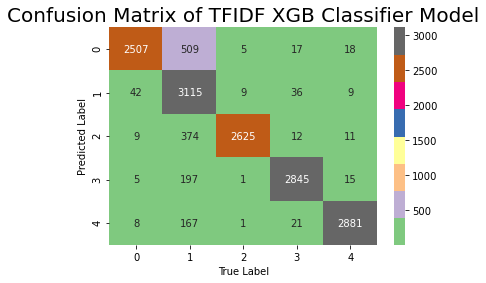

{0: 'DC Extended Universe', 1: 'Marvel Cinematic Universe', 2: 'MonsterVerse', 3: 'Star Wars', 4: 'Wizarding World'}
------------------------------------------------------------------------------------------------------------------------
('              precision    recall  f1-score   support\n'
 '\n'
 '           0       0.98      0.82      0.89      3056\n'
 '           1       0.71      0.97      0.82      3211\n'
 '           2       0.99      0.87      0.93      3031\n'
 '           3       0.97      0.93      0.95      3063\n'
 '           4       0.98      0.94      0.96      3078\n'
 '\n'
 '    accuracy                           0.91     15439\n'
 '   macro avg       0.93      0.90      0.91     15439\n'
 'weighted avg       0.93      0.91      0.91     15439\n')
Wall time: 35.2 s


In [64]:
%%time
tfidf_xgb_model = xgb.XGBClassifier(
        learning_rate=0.1,
        max_depth=7,
        n_estimators=80,
        use_label_encoder=False,
        eval_metric='auc')
tfidf_xgb_model, score_tfidf_xgb = evaluate_model(X_train_sv, y_train_sv, X_test_sv, y_test_sv, classes, 
                                         tfidf_xgb_model, "TFIDF XGB Classifier", "tfidf_xgb_model.pkl", fresh_load=True)

In [65]:
tf_idf_vectorizer = load(open('models/tfidf_stem_vector.pkl', 'rb'))
tfidf_xgb_model = load(open('models/tfidf_xgb_model.pkl', 'rb'))

In [66]:
list_f = sorted(glob.glob("output/final_output/df_rottentomatoes_reviews_predicted*"), key=os.path.getmtime)
output_file_name = list_f[0]
df_rottentomatoes_reviews = pd.read_csv(output_file_name)

In [67]:
%%time
val_acc_scr_tfidf_xgb, df_rottentomatoes_reviews = validate_model(tfidf_xgb_model, "TFIDF XGB Classifier", "tfidf_xgb", df_rottentomatoes_reviews, valid_tfidf_vec_list)

Validation Accuracy Score of TFIDF XGB Classifier Model created using stemmed tf_idf vector is:
 0.7320754716981132
Wall time: 8.04 s


In [68]:
#%%time
#get_cross_val(tfidf_xgb_model, X_train_sv, y_train_sv, X_test_sv, y_test_sv)

In [69]:
df_rottentomatoes_reviews.to_csv(output_file_name, index = False)
df_rottentomatoes_reviews

,review,movie_name,label_name,predicted_label_MNB,y_true,y_pred_MNB,predicted_label_tfidf_xgb,y_pred_tfidf_xgb,predicted_label_tfidf_knn,y_pred_tfidf_knn,predicted_label_we_mnb,y_pred_we_mnb
0,"2019's Godzilla: King of the Monsters, does pr...",godzilla_king_of_the_monsters_2019,MonsterVerse,MonsterVerse,2,2,MonsterVerse,2,MonsterVerse,2,Marvel Cinematic Universe,1
1,"Shazam!, it's wonderful. It's a very well-dire...",shazam,DC Extended Universe,DC Extended Universe,0,0,Marvel Cinematic Universe,1,DC Extended Universe,0,MonsterVerse,2
2,The crimes of Grindelwald is a very good film ...,fantastic_beasts_the_crimes_of_grindelwald,Wizarding World,Wizarding World,4,4,Marvel Cinematic Universe,1,Marvel Cinematic Universe,1,Marvel Cinematic Universe,1
3,An entertaining film with a great villain and ...,spider_man_homecoming,Marvel Cinematic Universe,Marvel Cinematic Universe,1,1,Marvel Cinematic Universe,1,MonsterVerse,2,Star Wars,3
4,Captain America: Civil War goes a darker direc...,captain_america_civil_war,Marvel Cinematic Universe,Marvel Cinematic Universe,1,1,Marvel Cinematic Universe,1,Marvel Cinematic Universe,1,Marvel Cinematic Universe,1
...,...,...,...,...,...,...,...,...,...,...,...,...
260,Shazam is fun and entertaining! It succeeds in...,shazam,DC Extended Universe,DC Extended Universe,0,0,DC Extended Universe,0,DC Extended Universe,0,Marvel Cinematic Universe,1
261,Godzilla: King of the Monsters was the first M...,godzilla_king_of_the_monsters_2019,MonsterVerse,MonsterVerse,2,2,MonsterVerse,2,MonsterVerse,2,Marvel Cinematic Universe,1
262,"Not quite top tier MCU, but very close. This i...",avengers_infinity_war,Marvel Cinematic Universe,Marvel Cinematic Universe,1,1,Marvel Cinematic Universe,1,Marvel Cinematic Universe,1,Wizarding World,4
263,There are a lot of mixed feeling about this mo...,thor_the_dark_world,Marvel Cinematic Universe,Marvel Cinematic Universe,1,1,Marvel Cinematic Universe,1,DC Extended Universe,0,MonsterVerse,2


In [70]:
score_tfidf_mnb.append(val_acc_scr_tfidf_mnb)
score_tfidf_svc.append(val_acc_scr_tfidf_svc)
score_tfidf_knn.append(val_acc_scr_tfidf_knn)
score_tfidf_rfc.append(val_acc_scr_tfidf_rfc)
score_tfidf_xgb.append(val_acc_scr_tfidf_xgb)
score = score_tfidf_mnb
score.extend(score_tfidf_svc)
score.extend(score_tfidf_knn)
score.extend(score_tfidf_rfc)
score.extend(score_tfidf_xgb)
score = [score]

In [107]:
df_score = pd.DataFrame(score)
df_score.columns = pd.MultiIndex.from_product([['MNB Accuracy', 'SVC Accuracy', 'KNN Accuracy', 'RFC Accuracy', 'XGB Accuracy'], ['Train','Test','Validate']])
df_score = df_score.set_index([['Basic Vectorisation']])
df_score[df_score.columns] = df_score[df_score.columns].applymap(lambda x: x*100)
df_score[df_score.columns] = df_score[df_score.columns].applymap("{0:.2f}%".format)
df_score

MNB Accuracy                  SVC Accuracy          \
                           Train    Test Validate        Train    Test   
Basic Vectorisation       96.18%  91.54%   74.34%       98.95%  91.72%   

                             KNN Accuracy                  RFC Accuracy  \
                    Validate        Train    Test Validate        Train   
Basic Vectorisation   64.91%       64.55%  46.54%   54.72%       99.23%   

                                     XGB Accuracy                   
                       Test Validate        Train    Test Validate  
Basic Vectorisation  91.83%   54.72%       91.04%  90.50%   73.21%

# <font color='orange'>  <center> Document Embeddings

In [72]:
df_embedding.head()

,lemma_cleaned_tokens,label,label_id
0,"['guardiansofthegalaxy', 'star', 'karengillan'...",Marvel Cinematic Universe,1
1,"['friend', 'show', 'idea', 'flash', 'guy', 'sh...",DC Extended Universe,0
2,"['papa', 'drago', 'godzilla', 'titan', 'omg']",MonsterVerse,2
3,"['batman', 'robin', 'camp']",DC Extended Universe,0
4,"['ant', 'man']",Marvel Cinematic Universe,1


In [73]:
print(list_embedding_data[:5])

['guardiansofthegalaxy star karengillan lot line marvel threequel', 'friend show idea flash guy show watch vote hour pick smt', 'papa drago godzilla titan omg', 'batman robin camp', 'ant man']


In [74]:
w2v_list = [l.split() for l in list_embedding_data]
w2v_model = Word2Vec(w2v_list,
                     vector_size=100,
                     window=5,
                     min_count=2,
                     sg=1)

In [75]:
words = ['star','vader','flash','batman','ironman','thanos','harry','godzilla','kong','king']
for i in range(len(words)):
    print(words[i], end="\t==>  ")
    similar = w2v_model.wv.most_similar(words[i], topn = 10)
    for j in range(len(similar)):
        print(similar[j][0],end =", ")
    print("\n")

star	==>  war, legostarwarstheskywalkersaga, nibellion, legostarwars, merchandise, zealand, legostarwarsgame, dlc, battlefront, lswgame, 

vader	==>  darth, maul, emperor, lightsaber, saber, prowse, anakin, kylo, apprentice, obi, 

flash	==>  food, cyborg, price, texas, filmchallenge, superman, drive, coupon, rainfall, mpd, 

batman	==>  riddler, catwoman, robin, reef, thebatman, gotham, pattinson, dceu, arkham, dccomics, 

ironman	==>  tonystark, rdj, titanic, happybirthdayrobertdowneyjr, robertdowneyjr, revnant, happybirthdayrdj, chaplin, pollos, celebrates, 

thanos	==>  verybadllama, infinity, gauntlet, snap, smtireland, population, stone, avenger, imjoker, reality, 

harry	==>  potter, sorteiopromodebooks, harrypotter, rowling, goblet, mugglenet, chamber, dobby, sirius, mcyt, 

godzilla	==>  kaiju, toho, mechagodzilla, monsterverse, gamera, mothra, ghidorah, anguirus, mecha, samgoji, 

kong	==>  gorilla, ape, bundy, godzillavskong, king, island, universalpics, babar, kohli, monste

In [76]:
dump(w2v_model, open("models/w2v_lemma_embedding.model", 'wb'))

In [77]:
w2v_model = Word2Vec.load("models/w2v_lemma_embedding.model")

In [78]:
X_emb = list_embedding_data
y_emb = df_embedding.label_id
X_train_emb, X_test_emb, y_train_emb, y_test_emb = train_test_split(X_emb, y_emb, test_size = 0.3, shuffle = True, stratify = y_emb, random_state = 3)

In [79]:
%%time
# load the pre-trained word-embedding vectors 
path = "G:\spark_big_files\\"
glove_file = path + 'glove.42B\glove.42B.300d.txt'
word_vec_file = path + 'wiki-news-300d-1M\wiki-news-300d-1M.vec'

Wall time: 0 ns


In [80]:
X_emb = pd.Series(list_embedding_data)
y_emb = df_embedding['label_id']
X_train_emb, X_test_emb, y_train_emb, y_test_emb = train_test_split(X_emb, y_emb, test_size = 0.3, shuffle = True, stratify = y_emb, random_state = 3)
train_emb = pd.concat([X_train_emb, y_train_emb], axis = 1)
test_emb = pd.concat([X_test_emb, y_test_emb], axis = 1)
train_emb.columns = ['full_text', 'label_id']
test_emb.columns = ['full_text', 'label_id']

In [81]:
train_emb

,full_text,label_id
15264,art raptorx joschuaknuppe image rex island scute,2
27836,fav godzilla,2
35958,creamycumshotz batman riddler,0
51126,johnxuandou wow series potter queer inclusivit...,4
14670,shitfuckers war gansters,3
...,...,...
31348,mcu marvel fan fun drama,1
28404,hack stay camera woman georgia mcdonalds film ...,3
4636,part memesmonday heard darth jar jar iron star...,3
25655,number people wandavision hawkeye anyone moon ...,1


In [82]:
%%time
glove_vectorizer = GloveVectorizer()

Xtrain_emb_glv = glove_vectorizer.fit_transform(train_emb.full_text)
Ytrain_emb_glv = train_emb.label_id

Xtest_emb_glv = glove_vectorizer.transform(test_emb.full_text)
Ytest_emb_glv = test_emb.label_id

Loading word vectors...
Found 1917494 word vectors.
Numer of samples with no words found: 255 / 36023
Numer of samples with no words found: 106 / 15439
Wall time: 2min 48s


In [83]:
list_f = sorted(glob.glob("output/final_output/df_rottentomatoes_reviews_predicted*"), key=os.path.getmtime)
output_file_name = list_f[0]
df_rottentomatoes_reviews = pd.read_csv(output_file_name)

In [84]:
%%time
X_valid_emb_glv = []
classes = {0: 'DC Extended Universe', 1: 'Marvel Cinematic Universe', 2: 'MonsterVerse', 3: 'Star Wars', 4: 'Wizarding World'}
for i in df_rottentomatoes_reviews.index:
    validation_text = df_rottentomatoes_reviews["review"][i]
    validation_text = preprocess_doc(validation_text, stem = False, lemma = True, stop_wrds = True, selected_tags = selected_tags)
    X_valid_emb_glv.append(validation_text)
X_valid_emb_glv = [" ".join(l) for l in X_valid_emb_glv]
X_valid_emb_glv = pd.Series(X_valid_emb_glv)
X_valid_emb_glv[:2]

Wall time: 10.2 s


0    godzilla monster thing people love see child g...
1    movie horror maestro comedy script way movie o...
dtype: object

In [85]:
X_valid_emb_gv = glove_vectorizer.transform(X_valid_emb_glv)
Y_valid_emb_gv = df_rottentomatoes_reviews['y_true']

Numer of samples with no words found: 0 / 265


# <font color='orange'>  <center> Word Embedding Multinomial Naive Bayes model

In [86]:
%%time
min_max_scaler = MinMaxScaler()
Xtrain_emb_glv_scaled = min_max_scaler.fit_transform(Xtrain_emb_glv)
Xtest_emb_glv_scaled = min_max_scaler.transform(Xtest_emb_glv)

Wall time: 136 ms


------------------------------------------------------------------------------------------------------------------------
Train Accuracy Score of Word Embedding Multinomial Naive Bayes model created using stemmed tf_idf vector is:
 0.7277850262332399
------------------------------------------------------------------------------------------------------------------------
Test Accuracy Score of Word Embedding Multinomial Naive Bayes model created using stemmed tf_idf vector is:
 0.7369648293283244
------------------------------------------------------------------------------------------------------------------------
Confusion Matrix:
[[1700 1293   26   25   12]
 [ 114 3035    5   48    9]
 [  82  825 2099   16    9]
 [  54  568    7 2424   10]
 [  62  836   27   33 2120]]


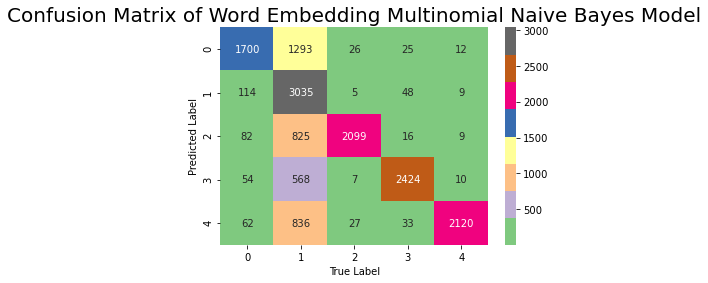

{0: 'DC Extended Universe', 1: 'Marvel Cinematic Universe', 2: 'MonsterVerse', 3: 'Star Wars', 4: 'Wizarding World'}
------------------------------------------------------------------------------------------------------------------------
('              precision    recall  f1-score   support\n'
 '\n'
 '           0       0.84      0.56      0.67      3056\n'
 '           1       0.46      0.95      0.62      3211\n'
 '           2       0.97      0.69      0.81      3031\n'
 '           3       0.95      0.79      0.86      3063\n'
 '           4       0.98      0.69      0.81      3078\n'
 '\n'
 '    accuracy                           0.74     15439\n'
 '   macro avg       0.84      0.73      0.75     15439\n'
 'weighted avg       0.84      0.74      0.75     15439\n')
Wall time: 602 ms


In [87]:
%%time
we_multi_naive_bayes_model = MultinomialNB()
we_multi_naive_bayes_model, score_we_mnb = evaluate_model(Xtrain_emb_glv_scaled, Ytrain_emb_glv, Xtest_emb_glv_scaled, Ytest_emb_glv, classes, 
                                         we_multi_naive_bayes_model, "Word Embedding Multinomial Naive Bayes", "we_multi_naive_bayes_model.pkl", fresh_load=True)

In [88]:
%%time
val_acc_scr_we_mnb, df_rottentomatoes_reviews = validate_wrd_emb_model(we_multi_naive_bayes_model, "Word embedded Multinomial Naive Bayes Model", "we_mnb", 
                                                                df_rottentomatoes_reviews, min_max_scaler.transform(X_valid_emb_gv))

Validation Accuracy Score of Word embedded Multinomial Naive Bayes Model Model created using lemmatized word embedding vector is:
 0.7132075471698113
Wall time: 4.98 ms


In [89]:
df_rottentomatoes_reviews.to_csv(output_file_name, index = False)

# <font color='orange'>  <center> Word Embedding Support Vector Classifier

------------------------------------------------------------------------------------------------------------------------
Train Accuracy Score of Word Embedding Support Vector Classifier model created using stemmed tf_idf vector is:
 0.9091691419370957
------------------------------------------------------------------------------------------------------------------------
Test Accuracy Score of Word Embedding Support Vector Classifier model created using stemmed tf_idf vector is:
 0.8792667918906665
------------------------------------------------------------------------------------------------------------------------
Confusion Matrix:
[[2619  284   78   30   45]
 [ 263 2758   71   62   57]
 [ 182  191 2605   20   33]
 [  86   84   29 2834   30]
 [ 143  118   26   32 2759]]


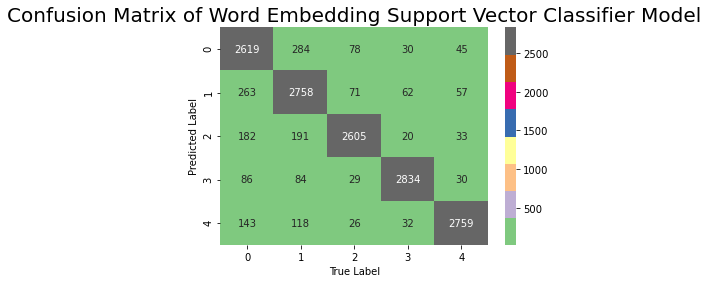

{0: 'DC Extended Universe', 1: 'Marvel Cinematic Universe', 2: 'MonsterVerse', 3: 'Star Wars', 4: 'Wizarding World'}
------------------------------------------------------------------------------------------------------------------------
('              precision    recall  f1-score   support\n'
 '\n'
 '           0       0.80      0.86      0.83      3056\n'
 '           1       0.80      0.86      0.83      3211\n'
 '           2       0.93      0.86      0.89      3031\n'
 '           3       0.95      0.93      0.94      3063\n'
 '           4       0.94      0.90      0.92      3078\n'
 '\n'
 '    accuracy                           0.88     15439\n'
 '   macro avg       0.88      0.88      0.88     15439\n'
 'weighted avg       0.88      0.88      0.88     15439\n')
Wall time: 7min 3s


In [90]:
%%time
wrd_emb_svc_model = SVC(kernel='rbf')
wrd_emb_svc_model, score_we_svc = evaluate_model(Xtrain_emb_glv, Ytrain_emb_glv, Xtest_emb_glv, Ytest_emb_glv, classes, 
                                         wrd_emb_svc_model, "Word Embedding Support Vector Classifier", "wrd_emb_svc_model.pkl", fresh_load=True)

In [91]:
%%time
val_acc_scr_we_svc, df_rottentomatoes_reviews = validate_wrd_emb_model(wrd_emb_svc_model, "Word Embedding Support Vector Classifier", "we_svc", 
                                                                df_rottentomatoes_reviews, X_valid_emb_gv)

Validation Accuracy Score of Word Embedding Support Vector Classifier Model created using lemmatized word embedding vector is:
 0.8943396226415095
Wall time: 1.91 s


In [92]:
df_rottentomatoes_reviews.to_csv(output_file_name, index = False)

# <font color='orange'>  <center> Word Embedding K-Nearest Neighbor(KNN)

------------------------------------------------------------------------------------------------------------------------
Train Accuracy Score of Word Embedding K-Nearest Neighbor(KNN) model created using stemmed tf_idf vector is:
 0.876717652610832
------------------------------------------------------------------------------------------------------------------------
Test Accuracy Score of Word Embedding K-Nearest Neighbor(KNN) model created using stemmed tf_idf vector is:
 0.8194831271455405
------------------------------------------------------------------------------------------------------------------------
Confusion Matrix:
[[2320  468  110   85   73]
 [ 359 2566  103  110   73]
 [ 220  268 2430   68   45]
 [  96  140   44 2751   32]
 [ 190  165   65   73 2585]]


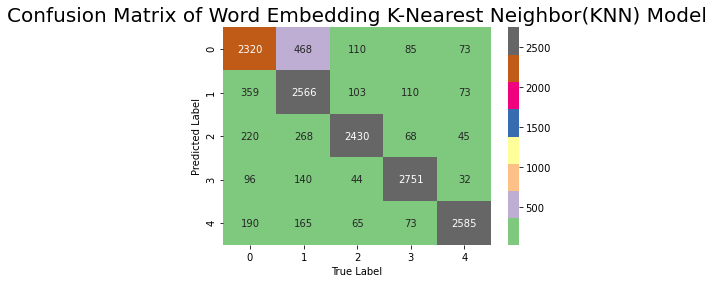

{0: 'DC Extended Universe', 1: 'Marvel Cinematic Universe', 2: 'MonsterVerse', 3: 'Star Wars', 4: 'Wizarding World'}
------------------------------------------------------------------------------------------------------------------------
('              precision    recall  f1-score   support\n'
 '\n'
 '           0       0.73      0.76      0.74      3056\n'
 '           1       0.71      0.80      0.75      3211\n'
 '           2       0.88      0.80      0.84      3031\n'
 '           3       0.89      0.90      0.89      3063\n'
 '           4       0.92      0.84      0.88      3078\n'
 '\n'
 '    accuracy                           0.82     15439\n'
 '   macro avg       0.83      0.82      0.82     15439\n'
 'weighted avg       0.83      0.82      0.82     15439\n')
Wall time: 1min 57s


In [93]:
%%time
wrd_emb_knn_model = KNeighborsClassifier(5)
wrd_emb_knn_model, score_we_knn = evaluate_model(Xtrain_emb_glv, Ytrain_emb_glv, Xtest_emb_glv, Ytest_emb_glv, classes, 
                                         wrd_emb_knn_model, "Word Embedding K-Nearest Neighbor(KNN)", "wrd_emb_knn_model.pkl", fresh_load=True)

In [94]:
%%time
val_acc_scr_we_knn, df_rottentomatoes_reviews = validate_wrd_emb_model(wrd_emb_knn_model, "Word Embedding K-Nearest Neighbor(KNN)", "we_knn", 
                                                                df_rottentomatoes_reviews, X_valid_emb_gv)

Validation Accuracy Score of Word Embedding K-Nearest Neighbor(KNN) Model created using lemmatized word embedding vector is:
 0.7320754716981132
Wall time: 506 ms


In [95]:
df_rottentomatoes_reviews.to_csv(output_file_name, index = False)

# <font color='orange'>  <center> Word Embedding Random Forest Classifier

------------------------------------------------------------------------------------------------------------------------
Train Accuracy Score of Word Embedding Random Forest Classifier model created using stemmed tf_idf vector is:
 0.9869527801682259
------------------------------------------------------------------------------------------------------------------------
Test Accuracy Score of Word Embedding Random Forest Classifier model created using stemmed tf_idf vector is:
 0.8527754388237581
------------------------------------------------------------------------------------------------------------------------
Confusion Matrix:
[[2545  388   47   30   46]
 [ 284 2764   57   56   50]
 [ 225  270 2489   23   24]
 [ 121  151   14 2749   28]
 [ 183  202   38   36 2619]]


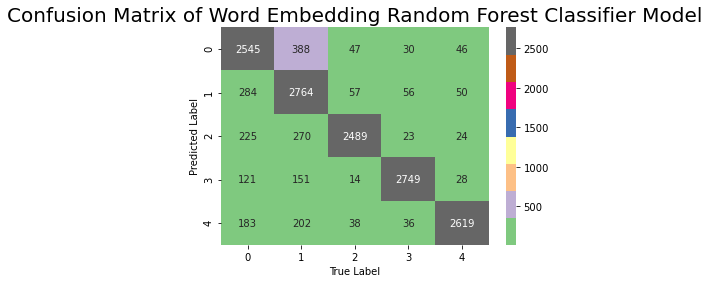

{0: 'DC Extended Universe', 1: 'Marvel Cinematic Universe', 2: 'MonsterVerse', 3: 'Star Wars', 4: 'Wizarding World'}
------------------------------------------------------------------------------------------------------------------------
('              precision    recall  f1-score   support\n'
 '\n'
 '           0       0.76      0.83      0.79      3056\n'
 '           1       0.73      0.86      0.79      3211\n'
 '           2       0.94      0.82      0.88      3031\n'
 '           3       0.95      0.90      0.92      3063\n'
 '           4       0.95      0.85      0.90      3078\n'
 '\n'
 '    accuracy                           0.85     15439\n'
 '   macro avg       0.87      0.85      0.86     15439\n'
 'weighted avg       0.86      0.85      0.86     15439\n')
Wall time: 4min 21s


In [96]:
%%time
wrd_emb_rndm_frst_model = RandomForestClassifier(n_estimators=200)
wrd_emb_rndm_frst_model, score_we_rfc = evaluate_model(Xtrain_emb_glv, Ytrain_emb_glv, Xtest_emb_glv, Ytest_emb_glv, classes, 
                                         wrd_emb_rndm_frst_model, "Word Embedding Random Forest Classifier", "wrd_emb_rndm_frst_model.pkl", fresh_load=True)

In [97]:
%%time
val_acc_scr_we_rfc, df_rottentomatoes_reviews = validate_wrd_emb_model(wrd_emb_rndm_frst_model, "Word Embedding Random Forest Classifier", "we_rfc", 
                                                                df_rottentomatoes_reviews, X_valid_emb_gv)

Validation Accuracy Score of Word Embedding Random Forest Classifier Model created using lemmatized word embedding vector is:
 0.8452830188679246
Wall time: 78.2 ms


In [98]:
df_rottentomatoes_reviews.to_csv(output_file_name, index = False)

# <font color='orange'>  <center> Word Embedding XGB Classifier

------------------------------------------------------------------------------------------------------------------------
Train Accuracy Score of Word Embedding XGB Classifier model created using stemmed tf_idf vector is:
 0.9843710962440663
------------------------------------------------------------------------------------------------------------------------
Test Accuracy Score of Word Embedding XGB Classifier model created using stemmed tf_idf vector is:
 0.8635274305330656
------------------------------------------------------------------------------------------------------------------------
Confusion Matrix:
[[2540  323   97   32   64]
 [ 278 2726   89   55   63]
 [ 185  198 2572   33   43]
 [  96  105   32 2790   40]
 [ 143  154   42   35 2704]]


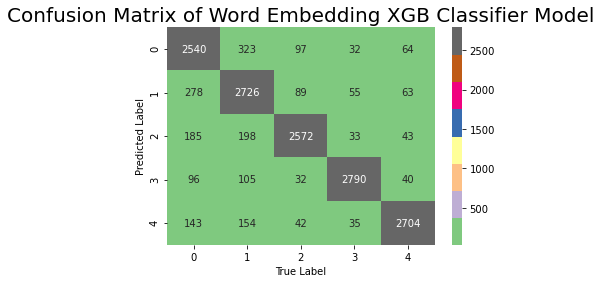

{0: 'DC Extended Universe', 1: 'Marvel Cinematic Universe', 2: 'MonsterVerse', 3: 'Star Wars', 4: 'Wizarding World'}
------------------------------------------------------------------------------------------------------------------------
('              precision    recall  f1-score   support\n'
 '\n'
 '           0       0.78      0.83      0.81      3056\n'
 '           1       0.78      0.85      0.81      3211\n'
 '           2       0.91      0.85      0.88      3031\n'
 '           3       0.95      0.91      0.93      3063\n'
 '           4       0.93      0.88      0.90      3078\n'
 '\n'
 '    accuracy                           0.86     15439\n'
 '   macro avg       0.87      0.86      0.87     15439\n'
 'weighted avg       0.87      0.86      0.86     15439\n')
Wall time: 8min 17s


In [99]:
%%time
we_xgb_model = xgb.XGBClassifier(
        learning_rate=0.1,
        max_depth=7,
        n_estimators=80,
        use_label_encoder=False,
        eval_metric='auc')
we_xgb_model, score_we_xgb = evaluate_model(Xtrain_emb_glv, Ytrain_emb_glv, Xtest_emb_glv, Ytest_emb_glv, classes, 
                                         we_xgb_model, "Word Embedding XGB Classifier", "we_xgb_model.pkl", fresh_load=True)

In [100]:
%%time
val_acc_scr_we_xgb, df_rottentomatoes_reviews = validate_wrd_emb_model(we_xgb_model, "Word Embedding XGB Classifier", "we_xgb", 
                                                                df_rottentomatoes_reviews, X_valid_emb_gv)

Validation Accuracy Score of Word Embedding XGB Classifier Model created using lemmatized word embedding vector is:
 0.8566037735849057
Wall time: 9.53 ms


In [101]:
df_rottentomatoes_reviews.to_csv(output_file_name, index = False)

In [102]:
score_we_mnb.append(val_acc_scr_we_mnb)
score_we_svc.append(val_acc_scr_we_svc)
score_we_knn.append(val_acc_scr_we_knn)
score_we_rfc.append(val_acc_scr_we_rfc)
score_we_xgb.append(val_acc_scr_we_xgb)
score_we = score_we_mnb
score_we.extend(score_we_svc)
score_we.extend(score_we_knn)
score_we.extend(score_we_rfc)
score_we.extend(score_we_xgb)
score_we = [score_we]

In [103]:
len(score_we[0])

15

In [109]:
df_score_we = pd.DataFrame(score_we)
df_score_we.columns = pd.MultiIndex.from_product([['MNB Accuracy', 'SVC Accuracy', 'KNN Accuracy', 'RFC Accuracy', 'XGB Accuracy'], ['Train','Test','Validate']])
df_score_we = df_score_we.set_index([['Word Embedding']])
df_score_we[df_score_we.columns] = df_score_we[df_score_we.columns].applymap(lambda x: x*100)
df_score_we[df_score_we.columns] = df_score_we[df_score_we.columns].applymap("{0:.2f}%".format)
df_score_we

MNB Accuracy                  SVC Accuracy                   \
                      Train    Test Validate        Train    Test Validate   
Word Embedding       72.78%  73.70%   71.32%       90.92%  87.93%   89.43%   

               KNN Accuracy                  RFC Accuracy                   \
                      Train    Test Validate        Train    Test Validate   
Word Embedding       87.67%  81.95%   73.21%       98.70%  85.28%   84.53%   

               XGB Accuracy                   
                      Train    Test Validate  
Word Embedding       98.44%  86.35%   85.66%

In [110]:
final_accuracy_df = pd.concat([df_score, df_score_we])
final_accuracy_df

MNB Accuracy                  SVC Accuracy          \
                           Train    Test Validate        Train    Test   
Basic Vectorisation       96.18%  91.54%   74.34%       98.95%  91.72%   
Word Embedding            72.78%  73.70%   71.32%       90.92%  87.93%   

                             KNN Accuracy                  RFC Accuracy  \
                    Validate        Train    Test Validate        Train   
Basic Vectorisation   64.91%       64.55%  46.54%   54.72%       99.23%   
Word Embedding        89.43%       87.67%  81.95%   73.21%       98.70%   

                                     XGB Accuracy                   
                       Test Validate        Train    Test Validate  
Basic Vectorisation  91.83%   54.72%       91.04%  90.50%   73.21%  
Word Embedding       85.28%   84.53%       98.44%  86.35%   85.66%

In [111]:
final_accuracy_df.to_csv("output/final_accuracy_nouns.csv")